#### [Dataset](https://drive.google.com/file/d/16ppXFTg46iTWxfls7tcrrBPovS7g2WxY/view?usp=sharing)

#### Importing libraries

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score

##### Loading dataset

In [5]:
sf_df = pd.read_csv('sf_air_traffic.csv')

In [6]:
sf_df.head()

,data_loaded_at,activity_period_start_date,data_as_of,activity_period,operating_airline,operating_airline_iata_code,published_airline,published_airline_iata_code,geo_summary,geo_region,activity_type_code,price_category_code,terminal,boarding_area,passenger_count
0,2024-10-22T15:01:56.000,1999-08-01T00:00:00.000,2024-10-20T13:00:51.000,199908,Champion Air,MG,Champion Air,MG,Domestic,US,Enplaned,Other,Terminal 1,A,1285
1,2024-10-22T15:01:56.000,2000-01-01T00:00:00.000,2024-10-20T13:00:51.000,200001,Lufthansa German Airlines,LH,Lufthansa German Airlines,LH,International,Europe,Enplaned,Other,Terminal 2,D,12222
2,2024-10-22T15:01:56.000,1999-09-01T00:00:00.000,2024-10-20T13:00:51.000,199909,United Airlines - Pre 07/01/2013,UA,United Airlines - Pre 07/01/2013,UA,International,Asia,Enplaned,Other,International,G,46391
3,2024-10-22T15:01:56.000,2000-01-01T00:00:00.000,2024-10-20T13:00:51.000,200001,Air Canada,AC,Air Canada,AC,International,Canada,Enplaned,Other,Terminal 1,B,17231
4,2024-10-22T15:01:56.000,1999-08-01T00:00:00.000,2024-10-20T13:00:51.000,199908,SkyWest Airlines,OO,United Airlines - Pre 07/01/2013,UA,Domestic,US,Enplaned,Other,Terminal 3,F,46152


In [7]:
sf_df['activity_period_start_date'] = pd.to_datetime(sf_df['activity_period_start_date'])

In [8]:
sf_df_dates = sf_df.groupby('activity_period_start_date').value_counts().sort_values(ascending=False)
print(f"Total non-unique activity start dates: {sf_df.shape[0] - sf_df_dates.shape[0]}")
print()

Total non-unique activity start dates: 316



##### Total entries per airline

In [9]:
sf_airlines = sf_df.groupby('published_airline').size().sort_values(ascending=False)
sf_airlines

published_airline
United Airlines                     4416
United Airlines - Pre 07/01/2013    4317
Alaska Airlines                     2526
Delta Air Lines                     1627
American Airlines                   1203
                                    ... 
Reno Air                               2
Harmony Airways                        1
Boeing Company                         1
Casino Express                         1
Samsic Airport America, LLC            1
Length: 124, dtype: int64

#### Columns

In [10]:
sf_df_united = sf_df[sf_df['published_airline'] == 'United Airlines']
sf_df_united

,data_loaded_at,activity_period_start_date,data_as_of,activity_period,operating_airline,operating_airline_iata_code,published_airline,published_airline_iata_code,geo_summary,geo_region,activity_type_code,price_category_code,terminal,boarding_area,passenger_count
58,2024-10-22T15:01:56.000,1999-07-01,2024-10-20T13:00:51.000,199907,United Airlines,UA,United Airlines,UA,Domestic,US,Enplaned,Other,Terminal 1,B,67479
83,2024-10-22T15:01:56.000,1999-08-01,2024-10-20T13:00:51.000,199908,United Airlines,UA,United Airlines,UA,Domestic,US,Enplaned,Other,Terminal 1,B,71503
133,2024-10-22T15:01:56.000,1999-10-01,2024-10-20T13:00:51.000,199910,United Airlines,UA,United Airlines,UA,Domestic,US,Deplaned,Other,Terminal 1,B,60355
195,2024-10-22T15:01:56.000,1999-12-01,2024-10-20T13:00:51.000,199912,United Airlines,UA,United Airlines,UA,Domestic,US,Enplaned,Other,Terminal 1,B,52065
270,2024-10-22T15:01:56.000,2000-02-01,2024-10-20T13:00:51.000,200002,United Airlines,UA,United Airlines,UA,Domestic,US,Enplaned,Other,Terminal 1,B,42253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36660,2024-10-22T15:01:56.000,2024-08-01,2024-10-20T13:00:52.000,202408,United Airlines,UA,United Airlines,UA,International,Europe,Enplaned,Other,International,G,75862
36665,2024-10-22T15:01:56.000,2024-08-01,2024-10-20T13:00:52.000,202408,United Airlines,UA,United Airlines,UA,International,Canada,Enplaned,Other,Terminal 3,F,6847
36674,2024-10-22T15:01:56.000,2024-08-01,2024-10-20T13:00:52.000,202408,United Airlines,UA,United Airlines,UA,International,Asia,Deplaned,Other,International,G,125889
36675,2024-10-22T15:01:56.000,2024-08-01,2024-10-20T13:00:52.000,202408,SkyWest Airlines,OO,United Airlines,UA,International,Canada,Deplaned,Other,Terminal 3,F,1501


In [11]:
sf_df_oldest_start_date = sf_df['activity_period_start_date']
sf_df_oldest_start_date = sf_df_oldest_start_date.iloc[0]
sf_df_oldest_start_date

Timestamp('1999-08-01 00:00:00')

In [12]:
sf_df_passenger_count_via_airlines = sf_df.groupby('published_airline')['passenger_count'].sum().sort_values(ascending=False)
sf_df_passenger_count_via_airlines

published_airline
United Airlines                     255611071
United Airlines - Pre 07/01/2013    231411449
American Airlines                    81166842
Delta Air Lines                      72648043
Alaska Airlines                      56253192
                                      ...    
Atlas Air, Inc                             68
Casino Express                             63
Samsic Airport America, LLC                56
Boeing Company                             18
Evergreen International Airlines            4
Name: passenger_count, Length: 124, dtype: int64

In [13]:
sf_df.describe()

,activity_period_start_date,activity_period,passenger_count
count,36680,36680.000000,36680.000000
mean,2012-08-17 18:27:42.988004352,201223.489831,27898.641358
min,1999-07-01 00:00:00,199907.000000,0.000000
25%,2006-06-01 00:00:00,200606.000000,4408.000000
50%,2013-01-01 00:00:00,201301.000000,8627.000000
75%,2018-11-01 00:00:00,201811.000000,19808.750000
max,2024-08-01 00:00:00,202408.000000,856501.000000
std,NaN,733.239760,62390.409543


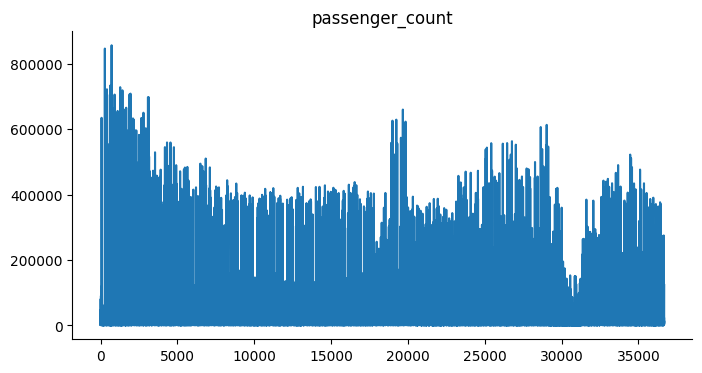

In [14]:
sf_df['passenger_count'].plot(kind='line', figsize=(8, 4), title='passenger_count')
plt.gca().spines[['top', 'right']].set_visible(False)

In [15]:
sf_df.isnull().sum()

data_loaded_at                   0
activity_period_start_date       0
data_as_of                       0
activity_period                  0
operating_airline                0
operating_airline_iata_code    316
published_airline                0
published_airline_iata_code    316
geo_summary                      0
geo_region                       0
activity_type_code               0
price_category_code              0
terminal                         0
boarding_area                    0
passenger_count                  0
dtype: int64

In [16]:
null_rows = sf_df[sf_df.isnull().any(axis=1)]
null_rows

,data_loaded_at,activity_period_start_date,data_as_of,activity_period,operating_airline,operating_airline_iata_code,published_airline,published_airline_iata_code,geo_summary,geo_region,activity_type_code,price_category_code,terminal,boarding_area,passenger_count
14,2024-10-22T15:01:56.000,1999-11-01,2024-10-20T13:00:51.000,199911,Aeroflot Russian International Airlines,NaN,Aeroflot Russian International Airlines,NaN,International,Europe,Deplaned,Other,Terminal 2,D,704
30,2024-10-22T15:01:56.000,1999-07-01,2024-10-20T13:00:51.000,199907,"China Eastern Airlines, Inc",NaN,"China Eastern Airlines, Inc",NaN,International,Asia,Deplaned,Other,Terminal 2,D,1794
50,2024-10-22T15:01:56.000,1999-09-01,2024-10-20T13:00:51.000,199909,Aeroflot Russian International Airlines,NaN,Aeroflot Russian International Airlines,NaN,International,Europe,Deplaned,Other,Terminal 2,D,850
55,2024-10-22T15:01:56.000,1999-11-01,2024-10-20T13:00:51.000,199911,Aeroflot Russian International Airlines,NaN,Aeroflot Russian International Airlines,NaN,International,Europe,Enplaned,Other,Terminal 2,D,535
81,2024-10-22T15:01:56.000,1999-12-01,2024-10-20T13:00:51.000,199912,"China Eastern Airlines, Inc",NaN,"China Eastern Airlines, Inc",NaN,International,Asia,Deplaned,Other,Terminal 2,D,1317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31029,2024-10-22T15:01:56.000,2021-05-01,2024-10-20T13:00:52.000,202105,Swissport USA,NaN,Swissport USA,NaN,Domestic,US,Enplaned,Other,International,A,93
31741,2024-10-22T15:01:56.000,2021-09-01,2024-10-20T13:00:52.000,202109,Swissport USA,NaN,Swissport USA,NaN,Domestic,US,Enplaned,Other,International,A,32
32096,2024-10-22T15:01:56.000,2022-02-01,2024-10-20T13:00:52.000,202202,Swissport USA,NaN,Swissport USA,NaN,Domestic,US,Enplaned,Other,International,A,41
32358,2024-10-22T15:01:56.000,2021-09-01,2024-10-20T13:00:52.000,202109,Swissport USA,NaN,Swissport USA,NaN,International,Asia,Enplaned,Other,International,A,251


In [17]:
sf = sf_df.dropna()

``` sf = sf.drop(columns=['data_loaded_at', 'activity_period_start_date', 'data_as_of'])```

#### dropped columns [`data_loaded_at`, `activity_period_start_date`, `data_as_of`]

In [18]:
sf = sf.drop(columns=['data_loaded_at', 'activity_period_start_date', 'data_as_of', 'operating_airline_iata_code', 'published_airline_iata_code'])

In [19]:
sf.head()

,activity_period,operating_airline,published_airline,geo_summary,geo_region,activity_type_code,price_category_code,terminal,boarding_area,passenger_count
0,199908,Champion Air,Champion Air,Domestic,US,Enplaned,Other,Terminal 1,A,1285
1,200001,Lufthansa German Airlines,Lufthansa German Airlines,International,Europe,Enplaned,Other,Terminal 2,D,12222
2,199909,United Airlines - Pre 07/01/2013,United Airlines - Pre 07/01/2013,International,Asia,Enplaned,Other,International,G,46391
3,200001,Air Canada,Air Canada,International,Canada,Enplaned,Other,Terminal 1,B,17231
4,199908,SkyWest Airlines,United Airlines - Pre 07/01/2013,Domestic,US,Enplaned,Other,Terminal 3,F,46152


In [20]:
sf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36364 entries, 0 to 36679
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   activity_period      36364 non-null  int64 
 1   operating_airline    36364 non-null  object
 2   published_airline    36364 non-null  object
 3   geo_summary          36364 non-null  object
 4   geo_region           36364 non-null  object
 5   activity_type_code   36364 non-null  object
 6   price_category_code  36364 non-null  object
 7   terminal             36364 non-null  object
 8   boarding_area        36364 non-null  object
 9   passenger_count      36364 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 3.1+ MB


### checking null values

In [21]:
sf.isnull().any()

activity_period        False
operating_airline      False
published_airline      False
geo_summary            False
geo_region             False
activity_type_code     False
price_category_code    False
terminal               False
boarding_area          False
passenger_count        False
dtype: bool

In [22]:
sf.columns

Index(['activity_period', 'operating_airline', 'published_airline',
       'geo_summary', 'geo_region', 'activity_type_code',
       'price_category_code', 'terminal', 'boarding_area', 'passenger_count'],
      dtype='object')

In [23]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
le = LabelEncoder()

# Specify columns to encode
columns_to_encode = ['operating_airline', 'published_airline',
                     'geo_summary', 'geo_region',
                     'activity_type_code', 'price_category_code',
                     'terminal', 'boarding_area']

# Encode columns in the data set
for column in columns_to_encode:
    sf[column] = le.fit_transform(sf[column])  # Fit on training set
sf.head()

,activity_period,operating_airline,published_airline,geo_summary,geo_region,activity_type_code,price_category_code,terminal,boarding_area,passenger_count
0,199908,36,32,0,8,1,1,2,0,1285
1,200001,71,61,1,4,1,1,3,3,12222
2,199909,109,95,1,0,1,1,0,6,46391
3,200001,7,7,1,2,1,1,2,1,17231
4,199908,91,95,0,8,1,1,4,5,46152


In [24]:
# Features and target
X = sf.drop(columns=['passenger_count'], axis=1)
y = sf['passenger_count']

# First split: Train (60%) and Test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)

# Second split: Validation (20%) and Test (20%) from the remaining data
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

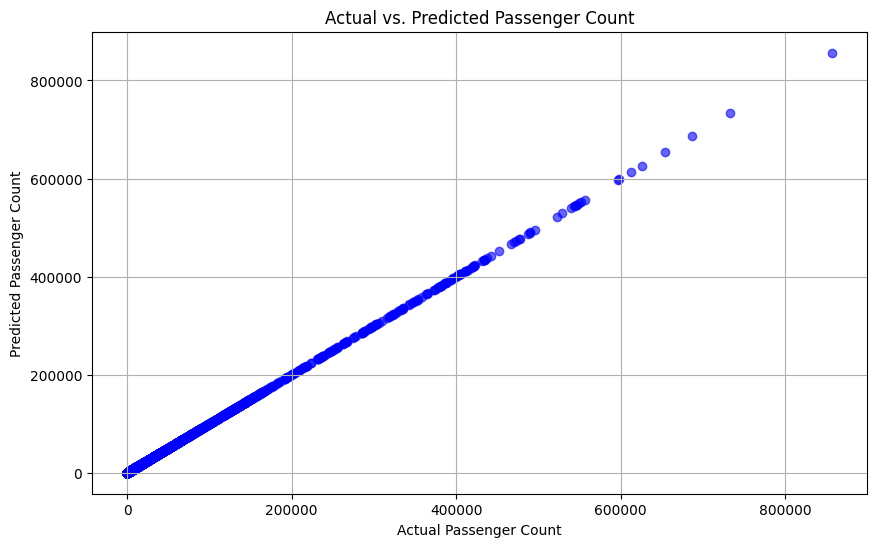

In [25]:
# scatter plot of y_test
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test, color='blue', label='Actual', alpha=0.6)
plt.xlabel('Actual Passenger Count')
plt.ylabel('Predicted Passenger Count')
plt.title('Actual vs. Predicted Passenger Count')
plt.grid(True)

In [26]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (21818, 9)
y_train shape: (21818,)
X_val shape: (7273, 9)
y_val shape: (7273,)
X_test shape: (7273, 9)
y_test shape: (7273,)


In [27]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=1)

In [28]:
rf_val_predictions = rf_model.predict(X_val)
rf_val_mae = mean_absolute_error(rf_val_predictions, y_val)

# print("Validation MAE for Random Forest Model: {}".format(rf_val_mae))

In [29]:
rf_predictions = rf_model.predict(X_test)
rf_mae = mean_absolute_error(rf_predictions, y_test)
rf_predictions = rf_predictions.astype(int)

# print("Test MAE for Random Forest Model: {}".format(rf_mae))
for i in range(5):
  print(f"Pred: {int(rf_predictions[i])} |  Actual: {y_test.iloc[i]}")
  print(f"Pred: {int(rf_predictions[i*-1])} |  Actual: {y_test.iloc[i*-1]}")

Pred: 1531 |  Actual: 1624
Pred: 1531 |  Actual: 1624
Pred: 6361 |  Actual: 7032
Pred: 6176 |  Actual: 8200
Pred: 4997 |  Actual: 3527
Pred: 1238 |  Actual: 1479
Pred: 1536 |  Actual: 1140
Pred: 157208 |  Actual: 155876
Pred: 1488 |  Actual: 1046
Pred: 8122 |  Actual: 31


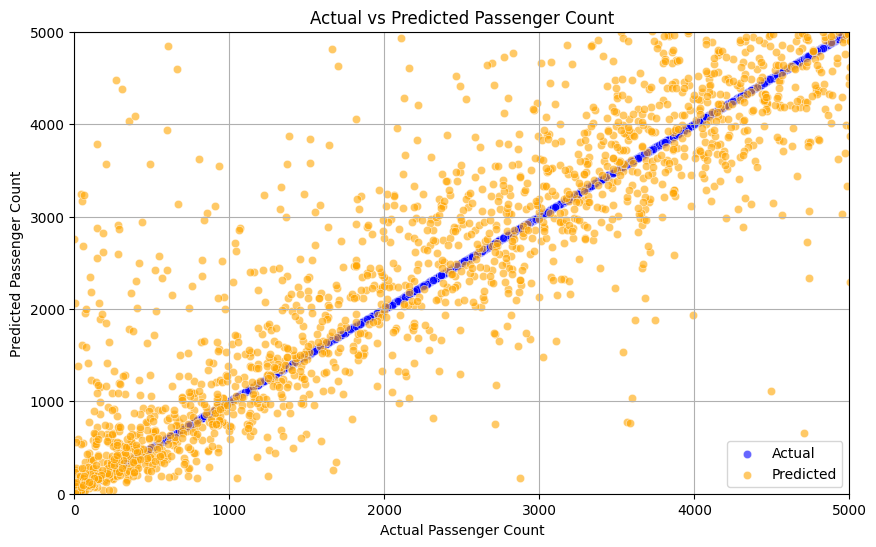

In [30]:
# Assuming you have your actual and predicted values
rf_predictions = rf_predictions.astype(int)
y_test = y_test.astype(int)

results_df = pd.DataFrame({
    'Actual Passenger Count': y_test,
    'Predicted Passenger Count': rf_predictions
})

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create a scatter plot
# sns.scatterplot(data=results_df, x='Actual Passenger Count', y='Predicted Passenger Count', alpha=0.6)

sns.scatterplot(data=results_df, x='Actual Passenger Count',
                 y='Actual Passenger Count',
                 color='blue', label='Actual', alpha=0.6)

# Scatter plot for predicted values
sns.scatterplot(data=results_df, x='Actual Passenger Count',
                 y='Predicted Passenger Count',
                 color='orange', label='Predicted', alpha=0.6)

# Add a line for perfect predictions
# max_count = max(results_df['Actual Passenger Count'].max(), results_df['Predicted Passenger Count'].max())
# plt.plot([0, max_count], [0, max_count], 'r--', linewidth=2, label='Prediction')
plt.xlim(0, 5000)  # Adjust these values based on your actual data range
plt.ylim(0, 5000)  # Adjust these values based on your actual data range

# Set labels and title
plt.xlabel('Actual Passenger Count')
plt.ylabel('Predicted Passenger Count')
plt.title('Actual vs Predicted Passenger Count')
plt.legend()
plt.grid()

plt.show()